In [2]:
from PyQt5 import QtCore, QtGui, QtWidgets
from untitled import Ui_MainWindow
from datetime import datetime
from scipy import signal
import sys
import urllib.request
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.fftpack

In [3]:
def Download():
    vstat = 'http://mgr.imces.ru/stdpub/mgr-baikal/hsg-irkutsk/48E8746F34325647_171025_162506.gr2'
    page = urllib.request.urlopen(vstat)
    content = page.read()
    type_file = vstat.split('.')
    if type_file[-1] == 'gr1':
        width = 8  # shirina fayla gr1
        numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B')).reshape(int(len(content) / width), width)
        length_column = int(len(
            content) / width) - 2  # вычитаем -2 так как первые 16 байтов являтся заголовком, каждая строка по 8 байтам и не читаем первые две строки
        numpy_date = np.array(numpy_data_polojitelnie[2:, :4], dtype=np.uint32)

    if type_file[-1] == 'gr2':
        width = 12  # shirina fayla gr2
        numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B')).reshape(int(len(content) / width), width)
        length_column = int(len(content) / width) - 1  # вычитаем -1 так как первые 12 байтов являтся заголовком
        numpy_date = np.array(numpy_data_polojitelnie[1:, :4], dtype=np.uint32)

    if type_file[-1] == 'mgr':
        width = 13  # shirina fayla mgr
        numpy_data_polojitelnie = np.frombuffer(content, dtype=np.dtype('B')).reshape(int(len(content) / width), width)
        length_column = int(len(content) / width) - 1  # вычитаем -1 так как первые 13 байтов являтся заголовком
        numpy_date_temp = np.array(numpy_data_polojitelnie[1:, :3], dtype=np.uint32)
        numpy_date = []
        b = np.array(numpy_date_temp, dtype='U2')
        for i in range(len(numpy_date_temp)):
            numpy_date.append(b[i, 0] + ':' + b[i, 1] + ':' + b[i, 2])
        array_date_obichniy_format = np.array(numpy_date, dtype='U7')
        # -----------------------------------------------------------------------------------------------------------------
    if width == 8:  # это означает что ширина = 8 то есть фалй gr1
        numpy_H1_amp_count = numpy_data_polojitelnie[2:, 4:6]
        numpy_H1_amplituda = numpy_data_polojitelnie[2:, 6:8]

    if width == 12:  # это означает что ширина = 12 то есть фалй gr2
        numpy_H1_amp_count = numpy_data_polojitelnie[1:, 4:6]
        numpy_H1_amplituda = numpy_data_polojitelnie[1:, 6:8]
        numpy_H2_amp_count = numpy_data_polojitelnie[1:, 8:10]
        numpy_H2_amplituda = numpy_data_polojitelnie[1:, 10:12]

    if width == 13:  # это означает что ширина = 13 то есть фалй mgr
        numpy_H1_amp_count = numpy_data_polojitelnie[1:, 3:5]
        numpy_H2_amp_count = numpy_data_polojitelnie[1:, 5:7]
        numpy_E_amp_count = numpy_data_polojitelnie[1:, 7:9]
        numpy_H1_amplituda = numpy_data_polojitelnie[1:, 9:11]
        numpy_H2_amplituda = numpy_data_polojitelnie[1:, 11:13]

        # -----------------------------------------------------------------------------------------------------------------

    def date_v_sekundax(massiv):
        s = np.zeros(length_column, dtype='uint64')
        for i in range(length_column):
            s[i] = massiv[i, 3] * (pow(16, 6)) + massiv[i, 1] * (pow(16, 4)) + massiv[i, 2] * (pow(16, 2)) + massiv[
                i, 0]
        return s

    if width == 8 or width == 12:
        array_date_v_sekundax = date_v_sekundax(numpy_date)

    def data_obichniy_format(massiv):
        s = np.zeros(length_column, dtype='<U40')  # "<U36"dlina simvolov
        for i in range(len(massiv)):
            s[i] = datetime.fromtimestamp(massiv[i] - 2209032000).strftime("%Y.%m.%d, %I:%M:%S")
        return s

    if width == 8 or width == 12:
        array_date_obichniy_format = data_obichniy_format(array_date_v_sekundax)

    def func_join_2_column(massiv):
        s = np.zeros(length_column, dtype='uint32')
        for i in range(length_column):
            s[i] = massiv[i, 0] + massiv[i, 1] * 16
        return s
        # -----------------------------------------------------------------------------------------------------------------

    if width == 8:
        array_H1_amp_count = func_join_2_column(numpy_H1_amp_count)
        array_H1_amplituda = func_join_2_column(numpy_H1_amplituda)

        dataset = pd.DataFrame(
            {'Time': array_date_obichniy_format, 'ImpulseNS': array_H1_amp_count, 'AmplitudaNS': array_H1_amplituda})

    if width == 12:
        array_H1_amp_count = func_join_2_column(numpy_H1_amp_count)
        array_H1_amplituda = func_join_2_column(numpy_H1_amplituda)
        array_H2_amp_count = func_join_2_column(numpy_H2_amp_count)
        array_H2_amplituda = func_join_2_column(numpy_H2_amplituda)

        dataset = pd.DataFrame(
            {'Time': array_date_obichniy_format, 'ImpulseNS': array_H1_amp_count, 'AmplitudaNS': array_H1_amplituda,
             'ImpulseWE': array_H2_amp_count,
             'AmplitudaWE': array_H2_amplituda})

    if width == 13:
        array_H1_amp_count = func_join_2_column(numpy_H1_amp_count)
        array_H2_amp_count = func_join_2_column(numpy_H2_amp_count)
        array_E_amp_count = func_join_2_column(numpy_E_amp_count)
        array_H1_amplituda = func_join_2_column(numpy_H1_amplituda)
        array_H2_amplituda = func_join_2_column(numpy_H2_amplituda)

        dataset = pd.DataFrame(
            {'Time': array_date_obichniy_format, 'ImpulseNS': array_H1_amp_count, 'AmplitudaNS': array_H1_amplituda,
             'ImpulseWE': array_H2_amp_count,
             'AmplitudaWE': array_H2_amplituda})

    return dataset

In [4]:
Download()

,Time,ImpulseNS,AmplitudaNS,ImpulseWE,AmplitudaWE
0,"2017.08.12, 10:23:00",760,25,31,210
1,"2017.08.13, 04:32:00",666,21,22,221
2,"2017.08.13, 04:33:00",888,252,30,212
3,"2017.08.13, 04:34:00",753,217,14,16
4,"2017.08.13, 04:35:00",882,16,27,200
5,"2017.08.13, 10:44:00",944,45,18,205
6,"2017.08.13, 10:45:00",870,19,33,203
7,"2017.08.13, 10:46:00",904,18,27,203
8,"2017.08.13, 10:47:00",983,22,34,205
9,"2017.08.13, 10:48:00",948,229,38,211


In [5]:
Download().set_index('Time',inplace=True)
Download()

,Time,ImpulseNS,AmplitudaNS,ImpulseWE,AmplitudaWE
0,"2017.08.12, 10:23:00",760,25,31,210
1,"2017.08.13, 04:32:00",666,21,22,221
2,"2017.08.13, 04:33:00",888,252,30,212
3,"2017.08.13, 04:34:00",753,217,14,16
4,"2017.08.13, 04:35:00",882,16,27,200
5,"2017.08.13, 10:44:00",944,45,18,205
6,"2017.08.13, 10:45:00",870,19,33,203
7,"2017.08.13, 10:46:00",904,18,27,203
8,"2017.08.13, 10:47:00",983,22,34,205
9,"2017.08.13, 10:48:00",948,229,38,211


In [6]:
mask = (Download()['Time'] > '2017.09.10') & (Download()['Time'] <= '2017.09.19')
periodopr = Download().loc[mask]

In [7]:
periodopr

,Time,ImpulseNS,AmplitudaNS,ImpulseWE,AmplitudaWE
159,"2017.09.10, 06:06:00",829,25,11,217
160,"2017.09.10, 06:07:00",794,234,0,0
161,"2017.09.10, 06:08:00",741,30,8,201
162,"2017.09.10, 06:09:00",910,29,2,210
163,"2017.09.11, 12:18:00",682,253,2,213
164,"2017.09.11, 12:19:00",648,252,9,74
165,"2017.09.11, 12:20:00",887,229,6,229
166,"2017.09.11, 12:21:00",848,55,8,207
167,"2017.09.11, 12:22:00",962,255,3,226
168,"2017.09.11, 06:31:00",812,24,9,250


In [8]:
x = periodopr['ImpulseNS']
x

159     829
160     794
161     741
162     910
163     682
164     648
165     887
166     848
167     962
168     812
169     985
170     973
171    1010
172     818
173     916
174     901
175    1009
176     821
177     837
178     977
179     907
180     918
181     786
182    1017
183     920
184     900
185    1008
186     918
187     914
188    1032
189     984
190    1067
191     850
192     910
193     916
194     825
195     983
196     883
197     999
198     963
199     978
200     857
201    1036
202     814
203     818
204    1035
205     871
206     927
207     984
208     911
209     914
Name: ImpulseNS, dtype: uint32

Text(0.5, 1.0, 'Выбранное значение для первого периода')

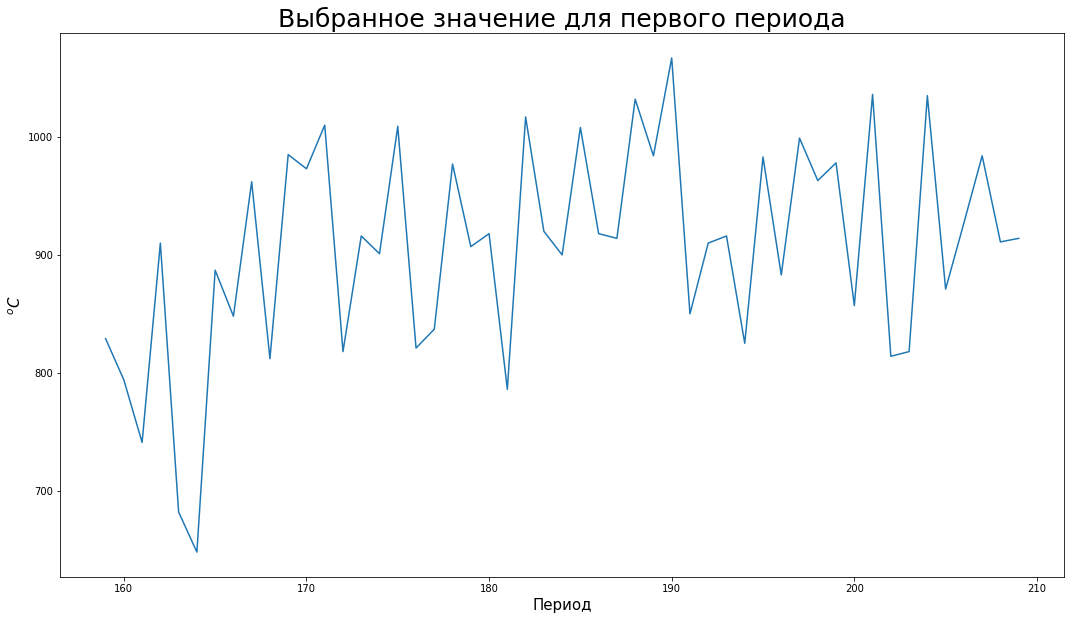

In [9]:
plt.figure(figsize=[18,10])
plt.plot(x)
plt.xlabel('Период', fontsize=15)
plt.ylabel('$^oC$', fontsize=15)
plt.title('Выбранное значение для первого периода', fontsize=25)

Text(0.5, 1.0, 'Преобразование Фурье')

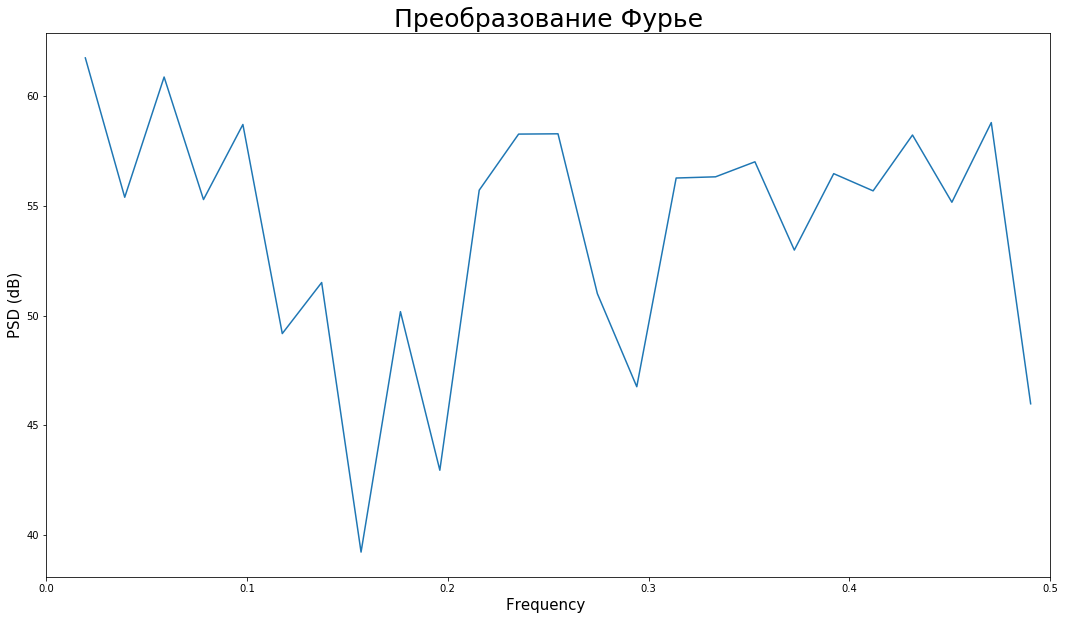

In [10]:
temp_fft = sp.fftpack.fft(x)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1)
i = fftfreq > 0
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 0.5)
ax.set_xlabel('Frequency ', fontsize=15)
ax.set_ylabel('PSD (dB)', fontsize=15)
plt.title('Преобразование Фурье', fontsize=25)

In [11]:
temp_fft

array([ 4.62050000e+04   +0.j        , -1.04304936e+03 +639.1320649j ,
       -4.69743042e+02 +354.51300221j, -4.55154376e+02+1008.61835566j,
        4.04248787e+02 +417.97201553j,  5.11693353e+02 +694.26973614j,
       -2.44597147e+02 +151.42776391j, -6.47966656e+01 -370.50127722j,
       -2.18260523e+01  +88.68163987j, -2.10932733e+02 -244.30946144j,
        1.40245249e+02   +6.0039744j , -5.79336180e+02 -193.52539696j,
       -5.01590529e+02 +648.6642309j ,  1.86066260e+02 +799.86143173j,
       -1.32209780e+02 -329.17975596j,  8.88995690e+01 +198.62164894j,
        4.74810699e+02 -445.47816162j,  6.53000000e+02  +53.69357503j,
        6.55377155e+02 +270.36345422j, -1.14972751e+02 +430.916939j  ,
       -3.48045956e+01 -665.23490183j, -5.45166500e+02 +270.64900817j,
       -3.19443504e+02 -750.88324608j, -3.10383374e+02 -481.97433441j,
       -7.83354378e+01 +867.51838892j,  4.90009592e+01 +192.85085057j,
        4.90009592e+01 -192.85085057j, -7.83354378e+01 -867.51838892j,
      

In [12]:
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from numpy.random import uniform
from math import sin, pi
import matplotlib.pyplot as plt

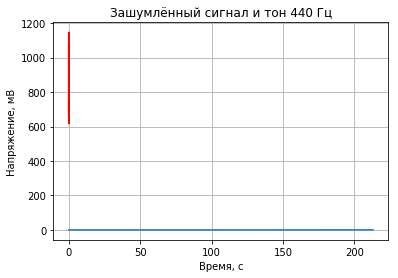

ValueError: n should be an integer

In [21]:
FD = 22050
spectrum = rfft(Download()['ImpulseNS'])

# нарисуем всё это, используя matplotlib
# Сначала сигнал зашумлённый и тон отдельно
plt.plot(arange(len(Download()['ImpulseNS']))/(Download()['ImpulseNS']), ) # по оси времени секунды!
plt.plot(arange(len(Download()['ImpulseNS']))/(Download()['ImpulseNS']), Download()['ImpulseNS'], 'r') # чистый сигнал будет нарисован красным
plt.xlabel(u'Время, c') # это всё запускалось в Python 2.7, поэтому юникодовские строки
plt.ylabel(u'Напряжение, мВ')
plt.title(u'Зашумлённый сигнал и тон 440 Гц')
plt.grid(True)
plt.show()
# когда закроется этот график, откроется следующий
# Потом спектр
plt.plot(rfftfreq(Download()['ImpulseNS'], 1./Download()['ImpulseNS']), np_abs(spectrum)/Download()['ImpulseNS'])
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в герцы
# нас интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы амплитуды были в милливольтах, а не в суммах Фурье. Проверить просто — постоянные составляющие должны совпадать в сгенерированном сигнале и в спектре
plt.xlabel(u'Частота, Гц')
plt.ylabel(u'Напряжение, мВ')
plt.title(u'Спектр')
plt.grid(True)
plt.show()